## Model Code

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CustomResNet(nn.Module):

    dropout_value = 0.1

    def __init__(self):
        super().__init__()
        # PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
        self.prep_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer1 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer1 - R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
        self.layer1_resblock = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer2 - Conv 3x3 [256k], MaxPooling2D, BN, ReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer3 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )
        # Layer3 - R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        self.layer3_resblock = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # MaxPooling with Kernel Size 4
        self.maxpool = nn.MaxPool2d(kernel_size=4)

        # FC Layer
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        # PrepLayer
        x = self.prep_layer(x)

        # Layer 1
        x = self.layer1(x)
        r1 = self.layer1_resblock(x)
        x = x + r1

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        x = self.layer3(x)
        r2 = self.layer3_resblock(x)
        x = x + r2

        # MaxPooling
        x = self.maxpool(x)

        # FC Layer
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        # Softmax
        return F.log_softmax(x, dim=-1)


## Utils

In [4]:
def mountDrive():
    from google.colab import drive
    drive.mount('/content/drive')

def cuda_availabilty():
    return torch.cuda.is_available()

def set_manualSeed(seed):
    # Sets the seed for PyTorch's Random Number Generator
    torch.manual_seed(seed)
    if cuda_availabilty():
        torch.cuda.manual_seed(seed)

def selectDevice():
    using_cuda = cuda_availabilty()
    print("Using CUDA!" if using_cuda else "Not using CUDA.")
    # if so select "cuda" as device for processing else "cpu"
    device = torch.device("cuda" if using_cuda else "cpu")
    return device

def download_MNIST(train, transform):
    from torchvision import datasets
    return datasets.MNIST('../data', train=train, download=True, transform=transform)

def download_CIFAR10(train, transform):
    from torchvision import datasets
    return datasets.CIFAR10('../data', train=train, download=True, transform=transform)

def stats_dataset(data):
    train_data = data.train_data
    train_data = data.transform(train_data.numpy())

    print('[Train]')
    print(' - Numpy Shape:', data.train_data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.train_data.size())
    print(' - min:', torch.min(train_data))     # Min Pixel Value
    print(' - max:', torch.max(train_data))     # Max Pixel Value
    print(' - mean:', torch.mean(train_data))
    print(' - std:', torch.std(train_data))
    print(' - var:', torch.var(train_data))

def view_dataset(data_loader, title):
    import matplotlib.pyplot as plt

    batch_data, batch_label = next(iter(data_loader))

    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(batch_data[i].squeeze(0).permute(1,2,0), cmap='gray')
      plt.title(batch_label[i].item())
      plt.xticks([])
      plt.yticks([])


def GetCorrectPredCount(pPrediction, pLabels ):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def viewAnalysis(train_losses, train_acc, test_losses, test_acc):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


def plotMisClassifiedImages(model, device, test_loader,classes):
    classes = test_data.classes
    model.eval()
    misClassifiedImages = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ~pred.eq(target.view_as(pred)).view(-1)
            misClassifiedImages.extend([(data[i], pred[i], target[i]) for i in range(len(idxs_mask)) if idxs_mask[i]])
            if len(misClassifiedImages) >= 10:
                break

    misClassifiedImages = misClassifiedImages[:10]

    fig, axes = plt.subplots(5, 2, figsize=(8, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (img, pred, target) in enumerate(misClassifiedImages):
        img, pred, target = img.cpu().numpy(), pred.cpu(), target.cpu()
        ax = axes[i//2, i%2]
        img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean  # De-normalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Predicted: {classes[pred.item()]}, Actual: {classes[target.item()]}')
        ax.axis('off')

    plt.show()

## Training & Testing

In [5]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get a batch of samples
        data, target = data.to(device) , target.to(device)
        # Initilizes the gradients to zero
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate Loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return train_acc, train_losses

def test(model, device, test_loader, criterion, test_acc, test_losses):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_acc, test_losses

## Main Code

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

100%|██████████| 170498071/170498071 [00:03<00:00, 43456440.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


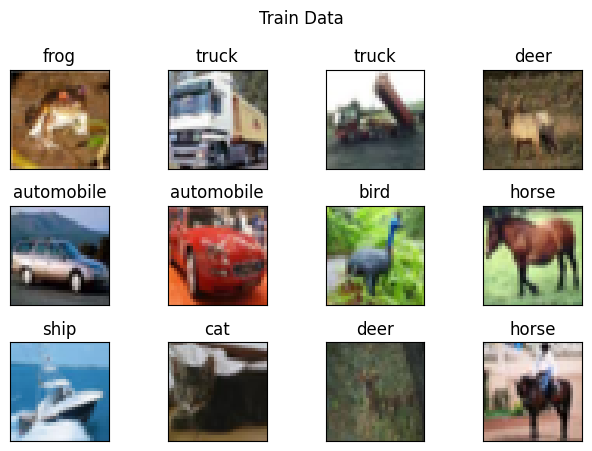

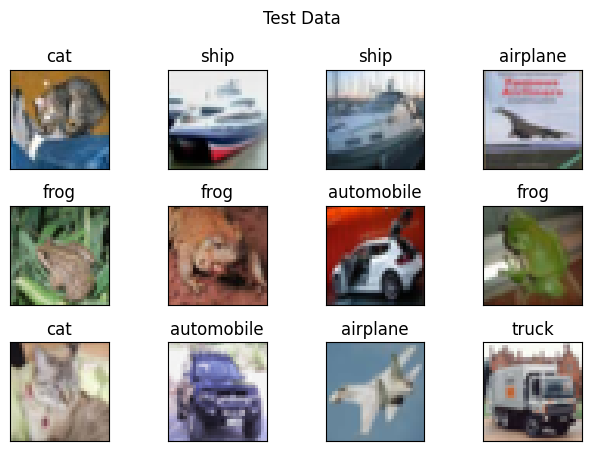

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# View the Training and Test Data
train_CIFAR = datasets.CIFAR10('./data', train=True, download=True)
test_CIFAR = datasets.CIFAR10('./data', train=False, download=True)

def showSampleImages(dataSet, title):
    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        img, label = dataSet[i]
        plt.imshow(img, cmap='gray')
        plt.title(dataSet.classes[label])
        plt.xticks([])
        plt.yticks([])

print('CIFAR classes :',train_CIFAR.classes)
showSampleImages(train_CIFAR, "Train Data")
showSampleImages(test_CIFAR, "Test Data")

Files already downloaded and verified
------ CIFAR10 Dataset Type and Classes ------
exp_CIFAR type =>  <class 'numpy.ndarray'>
------ CIFAR10 Sample Image - InTensor  ------
Files already downloaded and verified


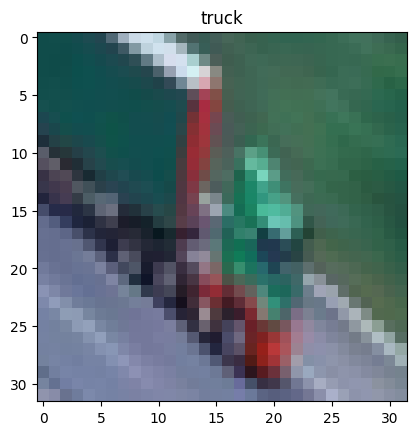

------ CIFAR10 Dataset MEAN & STD_DEV ------
Shape of CIFAR10 => torch.Size([3, 32, 32]) torch.float32
Mean of CIFAR10 =>  tensor([0.4914, 0.4822, 0.4465])
Std Dev of CIFAR10 =>  tensor([0.2470, 0.2435, 0.2616])
------ CIFAR10 Sample Image - Normalized ------


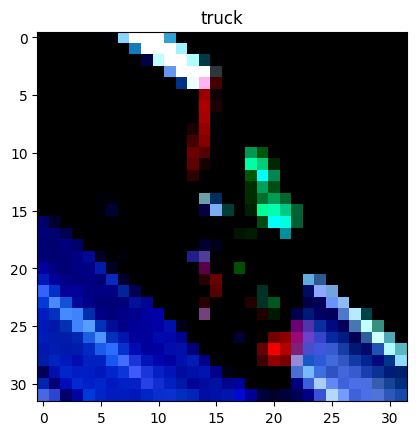

In [8]:
# Index of the sample image
idx = 50

# Download the dataset
exp_CIFAR = datasets.CIFAR10('./data', train=True, download=True)

print('------ CIFAR10 Dataset Type and Classes ------')
print('exp_CIFAR type => ',type(exp_CIFAR.data))

print('------ CIFAR10 Sample Image - InTensor  ------')
tns_CIFAR = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
img_t,label = tns_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

print('------ CIFAR10 Dataset MEAN & STD_DEV ------')
imgs = torch.stack([img_t for img_t ,_ in tns_CIFAR],dim=3)
imgs.shape
print('Shape of CIFAR10 =>', img_t.shape, img_t.dtype)
print('Mean of CIFAR10 => ',imgs.view(3,-1).mean(dim=1))
print('Std Dev of CIFAR10 => ',imgs.view(3, -1).std(dim=1))

print('------ CIFAR10 Sample Image - Normalized ------')
trs_CIFAR = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))
img_t,label = trs_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean_val = [0.4915, 0.4823, 0.4466]
std_val = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


In [10]:
import cv2
import os
import copy
from torch.utils.data import Dataset
from torchvision import datasets

class CIFAR10_Transforms(Dataset):
    def __init__(self, dataset, transforms):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.dataset[idx]

        # Apply transformations on the image
        image = self.transforms(image=np.array(image))["image"]

        return image, label

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

    def __str__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

train_data = datasets.CIFAR10('../data', train=True, download=True)
test_data = datasets.CIFAR10('../data', train=False, download=True)

train_data = CIFAR10_Transforms(train_data, train_transforms)
test_data = CIFAR10_Transforms(test_data, test_transforms)


100%|██████████| 170498071/170498071 [00:03<00:00, 43180297.67it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [11]:
# Set the seed for Reproducible results
SEED = 1
set_manualSeed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda_availabilty() else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


In [12]:
from torchsummary import summary
device = selectDevice()
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14       

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-01


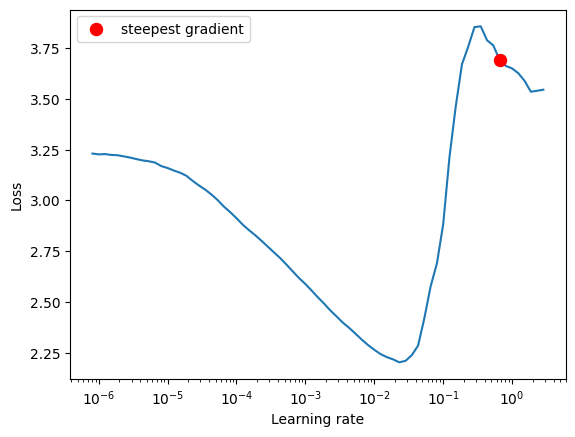

In [13]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [14]:
from torch.optim.lr_scheduler import OneCycleLR
num_epoch = 24

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=2e-3, epochs=num_epoch, steps_per_epoch=1, \
                                          pct_start=0.2, div_factor=5)

criterion = F.nll_loss

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)
    scheduler.step()

Epoch :  0


Train: Loss=1.2984 Batch_id=97 Accuracy=41.90: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]


Test set: Average loss: 1.3858, Accuracy: 5032/10000 (50.32%)

Epoch :  1


Train: Loss=0.9645 Batch_id=97 Accuracy=61.27: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Test set: Average loss: 0.9355, Accuracy: 6716/10000 (67.16%)

Epoch :  2


Train: Loss=0.7725 Batch_id=97 Accuracy=70.05: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Test set: Average loss: 0.6795, Accuracy: 7610/10000 (76.10%)

Epoch :  3


Train: Loss=0.6575 Batch_id=97 Accuracy=76.08: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 0.6475, Accuracy: 7777/10000 (77.77%)

Epoch :  4


Train: Loss=0.5079 Batch_id=97 Accuracy=79.56: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Test set: Average loss: 0.7443, Accuracy: 7575/10000 (75.75%)

Epoch :  5


Train: Loss=0.4904 Batch_id=97 Accuracy=82.34: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Test set: Average loss: 0.5270, Accuracy: 8287/10000 (82.87%)

Epoch :  6


Train: Loss=0.3823 Batch_id=97 Accuracy=84.07: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Test set: Average loss: 0.4634, Accuracy: 8454/10000 (84.54%)

Epoch :  7


Train: Loss=0.4120 Batch_id=97 Accuracy=85.67: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Test set: Average loss: 0.5081, Accuracy: 8433/10000 (84.33%)

Epoch :  8


Train: Loss=0.3939 Batch_id=97 Accuracy=87.29: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Test set: Average loss: 0.4408, Accuracy: 8510/10000 (85.10%)

Epoch :  9


Train: Loss=0.3149 Batch_id=97 Accuracy=88.40: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.3841, Accuracy: 8738/10000 (87.38%)

Epoch :  10


Train: Loss=0.2000 Batch_id=97 Accuracy=89.51: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Test set: Average loss: 0.3574, Accuracy: 8822/10000 (88.22%)

Epoch :  11


Train: Loss=0.2691 Batch_id=97 Accuracy=90.61: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Test set: Average loss: 0.3394, Accuracy: 8883/10000 (88.83%)

Epoch :  12


Train: Loss=0.2492 Batch_id=97 Accuracy=91.41: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Test set: Average loss: 0.3086, Accuracy: 8990/10000 (89.90%)

Epoch :  13


Train: Loss=0.2556 Batch_id=97 Accuracy=92.22: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.2892, Accuracy: 9020/10000 (90.20%)

Epoch :  14


Train: Loss=0.1757 Batch_id=97 Accuracy=92.73: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.3364, Accuracy: 8870/10000 (88.70%)

Epoch :  15


Train: Loss=0.2024 Batch_id=97 Accuracy=93.67: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Test set: Average loss: 0.2889, Accuracy: 9077/10000 (90.77%)

Epoch :  16


Train: Loss=0.2138 Batch_id=97 Accuracy=94.37: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Test set: Average loss: 0.2673, Accuracy: 9132/10000 (91.32%)

Epoch :  17


Train: Loss=0.1552 Batch_id=97 Accuracy=95.02: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.2702, Accuracy: 9150/10000 (91.50%)

Epoch :  18


Train: Loss=0.1512 Batch_id=97 Accuracy=95.64: 100%|██████████| 98/98 [00:21<00:00,  4.67it/s]


Test set: Average loss: 0.2486, Accuracy: 9231/10000 (92.31%)

Epoch :  19


Train: Loss=0.1317 Batch_id=97 Accuracy=95.98: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]


Test set: Average loss: 0.2469, Accuracy: 9230/10000 (92.30%)

Epoch :  20


Train: Loss=0.1049 Batch_id=97 Accuracy=96.39: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Test set: Average loss: 0.2428, Accuracy: 9232/10000 (92.32%)

Epoch :  21


Train: Loss=0.1049 Batch_id=97 Accuracy=96.50: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Test set: Average loss: 0.2414, Accuracy: 9245/10000 (92.45%)

Epoch :  22


Train: Loss=0.1025 Batch_id=97 Accuracy=96.57: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


Test set: Average loss: 0.2401, Accuracy: 9237/10000 (92.37%)

Epoch :  23


Train: Loss=0.0844 Batch_id=97 Accuracy=96.68: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.2399, Accuracy: 9240/10000 (92.40%)



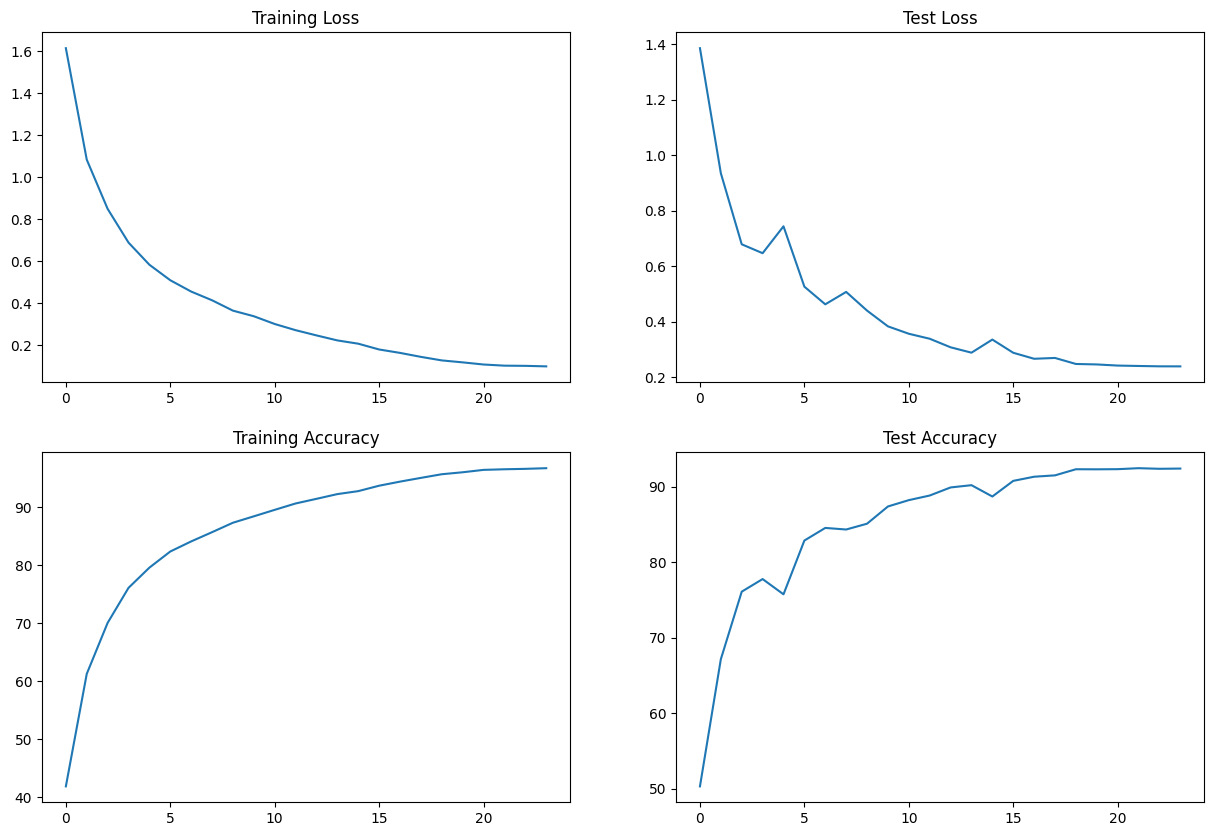

In [15]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)